In [14]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt

In [1]:
# code examples presented in Python
bcr = 0.10  # baseline conversion rate
d_hat = 0.02  # difference between the groups

In [3]:
# A is control; B is test
N_A = 1000
N_B = 1000

Because this is a hypothetical example, we will need “fake” data to work on. I wrote a function that will generate data for our simulation. 

In [42]:
def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    """Returns a pandas dataframe with fake CTR data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
    Returns:
        df (df)
    """

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    group_bern = scs.bernoulli(0.5)

    # initiate bernoulli distributions to randomly sample from
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

In [43]:
ab_data = generate_data(N_A, N_B, bcr, d_hat)

In [44]:
ab_data.head()

,converted,group
0,0,B
1,0,A
2,0,A
3,1,A
4,0,B


Let’s look at a summary of the results using the pivot table function in Pandas.

In [45]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary

,converted
group,
A,82
B,25


In [46]:
# add additional columns to the pivot table
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

In [47]:
ab_summary

,converted,total,rate
group,,,
A,82,982,0.083503
B,25,1018,0.024558


It looks like the difference in conversion rates between the two groups is 0.028 which is greater than the lift we initially wanted of 0.02. This is a good sign but this is not enough evidence for us to confidently go with the new design. At this point we have not measured how confident we are in this result. This can be mitigated by looking at the distributions of the two groups.

In [50]:
A_converted = ab_summary['converted']['A']
A_total = ab_summary['total']['A']
A_cr = ab_summary['rate']['A']

B_cr = ab_summary['rate']['B']
B_converted = ab_summary['converted']['B']

Text(0, 0.5, 'probability')

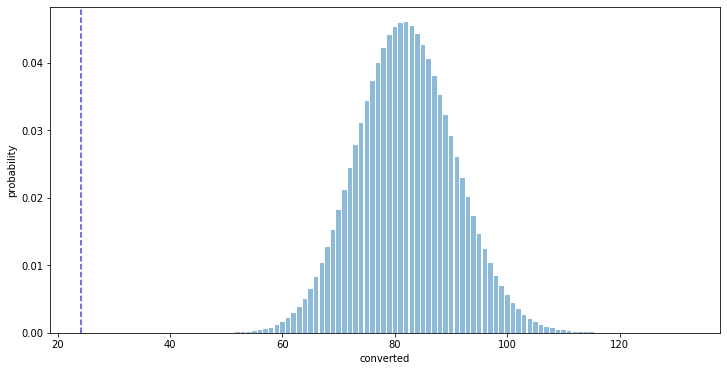

In [52]:
fig, ax = plt.subplots(figsize=(12,6))

x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, A_cr).pmf(x)

ax.bar(x, y, alpha=0.5)
ax.axvline(x=(B_cr * A_total), c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')